In [1]:
import warnings
warnings.filterwarnings('ignore') 

import sys
sys.path.append('../')

from Network import Network
from Environment import CyberAttack 
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import spearmanr

In [2]:
network = Network(1000,random_state=0).network

In [3]:
results = np.zeros(len(network))

for file in glob.glob("Single_Run_Results/*"):
    results += np.load(file)

In [4]:
network["RL_Breach_Probability"] = results/10000
network["Number_Connections"] = network["All_Connections"].apply(lambda x: len(x))
network["Number_Outgoing_Connections"] = network["Outgoing_Connections"].apply(lambda x: len(x))
network["Number_Incoming_Connections"] = network["Incoming_Connections"].apply(lambda x: len(x))

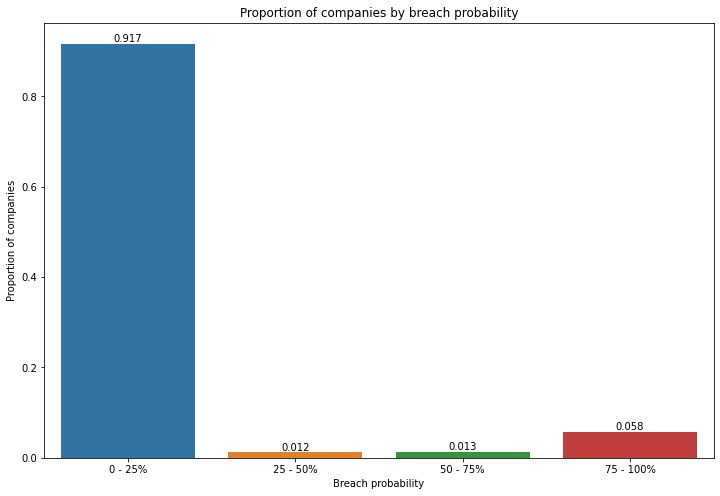

In [5]:
bin_1 = 0
bin_2 = 0
bin_3 = 0
bin_4 = 0
for i in range(len(network)):
    if network["RL_Breach_Probability"][i] <= .25:
        bin_1 += 1
    elif network["RL_Breach_Probability"][i] <= .50:
        bin_2 += 1
    elif network["RL_Breach_Probability"][i] <= .75:
        bin_3 += 1
    else:
        bin_4 += 1   
bin_1,bin_2,bin_3,bin_4 = bin_1/1000,bin_2/1000,bin_3/1000,bin_4/1000

fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot([0,1,2,3],[bin_1,bin_2,bin_3,bin_4],ax=ax)
ax.set_title("Proportion of companies by breach probability")
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2., height,
                height,
                ha="center",va="bottom",rotation=0,color="black")
autolabel(ax.patches)
ax.set_xticks(ticks=[0,1,2,3],labels=["0 - 25%","25 - 50%","50 - 75%","75 - 100%"])
ax.set_xlabel("Breach probability")
ax.set_ylabel("Proportion of companies")
plt.show()

In [6]:
for feature in ["Size","Number_Connections","Number_Incoming_Connections","Number_Outgoing_Connections"]:
    rho,p = spearmanr(network[feature],network["RL_Breach_Probability"])
    print(f"{feature}: Rho = {rho:.2f}, p = {round(p,2)}")    

Size: Rho = 0.23, p = 0.0
Number_Connections: Rho = 0.08, p = 0.01
Number_Incoming_Connections: Rho = 0.10, p = 0.0
Number_Outgoing_Connections: Rho = 0.04, p = 0.22


In [7]:
y = network["RL_Breach_Probability"]
X = network[["Size","Number_Connections","Number_Incoming_Connections","Number_Outgoing_Connections"]]
X_ = sm.add_constant(X)
X_ = X_.astype(float)
model = sm.OLS(y,X_).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     RL_Breach_Probability   R-squared:                       0.149
Model:                               OLS   Adj. R-squared:                  0.147
Method:                    Least Squares   F-statistic:                     58.23
Date:                   Sun, 04 Dec 2022   Prob (F-statistic):           1.10e-34
Time:                           11:30:20   Log-Likelihood:                 125.66
No. Observations:                   1000   AIC:                            -243.3
Df Residuals:                        996   BIC:                            -223.7
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          -0.0979      0.021     -4.748      0.000      -0.138      -0.057
Size                         6.699e-06   5.34e-07     12.535      0.000    5.65e-06    7.75e-06
Number_Connections              0.0020      0.001      3.372      0.001       0.001       0.003
Number_Incoming_Connections    -0.0022      0.001     -3.921      0.000      -0.003      -0.001
Number_Outgoing_Connections     0.0042      0.001      3.653      0.000       0.002       0.006
==============================================================================
Omnibus:                      540.002   Durbin-Watson:                   1.918
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2933.303
Skew:                           2.568   Prob(JB):                         0.00
Kurtosis:                       9.635   Cond. No.                     2.86e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.38e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""